In [1]:
# based on https://github.com/ageron/tiny-dqn
    
from __future__ import division, print_function, unicode_literals

from collections import deque
import gym
import numpy as np
import numpy.random as rnd
import os
import tensorflow as tf
from tensorflow.contrib.layers import convolution2d, fully_connected

env = gym.make("MsPacman-v0")
done = True  # env needs to be reset



[2017-07-01 14:00:48,403] Making new env: MsPacman-v0


In [2]:
# TensorFlow - Construction phase
input_height = 88
input_width = 80
input_channels = 1  # we only look at one frame at a time, so ghosts and power pellets really are invisible when they blink
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_inputs = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # MsPacman has 9 actions: upper left, up, upper right, left, and so on.
initializer = tf.contrib.layers.variance_scaling_initializer() # He initialization
learning_rate = 0.01

def q_network(X_state, scope):
    prev_layer = X_state
    conv_layers = []
    with tf.variable_scope(scope) as scope:
        for n_maps, kernel_size, stride, padding, activation in zip(conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation):
            prev_layer = convolution2d(prev_layer, num_outputs=n_maps, kernel_size=kernel_size, stride=stride, padding=padding, activation_fn=activation, weights_initializer=initializer)
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_inputs])
        hidden = fully_connected(last_conv_layer_flat, n_hidden, activation_fn=hidden_activation, weights_initializer=initializer)
        outputs = fully_connected(hidden, n_outputs, activation_fn=None)
    trainable_vars = {var.name[len(scope.name):]: var for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
    return outputs, trainable_vars

In [3]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
actor_q_values, actor_vars = q_network(X_state, scope="q_networks/actor")    # acts

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(actor_q_values * tf.one_hot(X_action, n_outputs),  # was critic_q_values before
                            reduction_indices=1, keep_dims=True)
    cost = tf.reduce_mean(tf.square(y - q_value))
    global_step = tf.Variable(0, trainable=False, name="global_step")
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [4]:
# Replay memory, epsilon-greedy policy and observation preprocessing
replay_memory_size = 1000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = rnd.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

epsilon_min = 0.05
epsilon_max = 1.0
n_steps = 2000
epsilon_decay_steps = n_steps // 2
epsilon = epsilon_max

def epsilon_greedy(q_values, epsilon):
    if rnd.rand() < epsilon:
        return rnd.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.mean(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img - 128) / 128 - 1 # normalize from -1. to 1.
    return img.reshape(88, 80, 1)

# TensorFlow - Execution phase

learning_start_iteration = 1000
learning_every_n_iterations = 3
batch_size = 50
discount_rate = 0.95
skip_start = 90
iteration = 0
scores = []

In [5]:
verbosity = 1
render = True
save_steps = 50
copy_steps = 25
loss = 0.
score = 0.

with tf.Session() as sess:
    if os.path.isfile("my_dqn.ckp"):  # restores a previous version
        saver.restore(sess, "my_dqn.ckp")
    else:
        init.run()
    
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if verbosity > 0:
            print("\rIteration {}\tTraining step {}/{} ({:.1f}%)\tepsilon={:.2f}\tloss: {:.2f}".format(iteration, step, n_steps, step * 100 / n_steps, epsilon, loss/step), end="")
        if done: # game over, start again
            scores.append(score)
            score = 0.
            obs = env.reset()
            for skip in range(skip_start): # skip boring game iterations at the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)
        if render:
            env.render()

        # Actor evaluates what to do
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        epsilon = max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * global_step.eval() / epsilon_decay_steps)
        action = epsilon_greedy(q_values, epsilon)

        # Actor plays
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        score += reward

        # Let's memorize what just happened
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Critic learns
        if iteration > learning_start_iteration and iteration % learning_every_n_iterations == 0:
            X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)
            # TODO I don't understand this line of code
            next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})  # (50,9)
            # TODO I don't understand this line of code
            y_val = rewards + continues * discount_rate * np.max(next_q_values, axis=1, keepdims=True)
            _, _loss = sess.run([training_op, cost], feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})
            loss += _loss

            if global_step.eval() % save_steps == 0:
                saver.save(sess, "my_dqn.ckp")

/Users/sinanozdemir/Dropbox/CODE/personal_code/personal_code/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Iteration 6999	Training step 1999/2000 (100.0%)	epsilon=0.05	loss: 87513681347.89

In [9]:
def running_mean(l, N):
    sum = 0
    result = list( 0 for x in l)

    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)

    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N

    return result

In [11]:
scores

[0.0,
 210.0,
 80.0,
 130.0,
 600.0,
 1720.0,
 400.0,
 580.0,
 640.0,
 500.0,
 170.0,
 140.0]

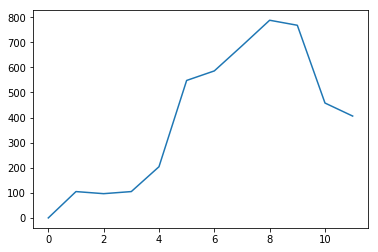

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

avg_scores = running_mean(scores, 5)
plt.plot(range(len(avg_scores)), avg_scores);
plt.show()

In [8]:
fuck yea

SyntaxError: invalid syntax (<ipython-input-8-a5091eaea9bb>, line 1)

In [ ]:
X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)

In [ ]:
X_state_val.shape

In [ ]:
X_action_val

In [ ]:
rewards.reshape(50,)

In [ ]:
X_next_state_val.shape

In [ ]:
# TODO I don't understand this line of code
next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
# TODO I don't understand this line of code
y_val = rewards + continues * discount_rate * np.max(next_q_values, axis=1, keepdims=True)